In [1]:
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
from sklearn import metrics
from sklearn.model_selection import train_test_split
from keras.models import Sequential, Model
from keras.layers import Dense
from keras.layers import Flatten
from keras.layers import Dropout
from keras.callbacks import ModelCheckpoint
from keras.layers.convolutional import Conv1D
from keras.layers.convolutional import MaxPooling1D
RANDOM_SEED = 42

Using TensorFlow backend.


## Load Dataset

In [2]:
dataset_path = './data/SingleChest/'
activity_folders = os.listdir(dataset_path)
print(activity_folders)

data_frame = pd.DataFrame()
df_list = []

for i in range(len(activity_folders)):
    activity_folder = activity_folders[i]
    print(activity_folder)
    
    person_folder_path = dataset_path + activity_folder + '/'
    person_folders = os.listdir(person_folder_path)
    
    for j in range(len(person_folders)):
        person_folder = person_folders[j]
        #print(person_folder)
        
        csv_file_path = dataset_path + activity_folder + '/' + person_folder + '/'
        csv_files = os.listdir(csv_file_path)
        
        for k in range(len(csv_files)):
            csv_file = csv_files[k]
            #print(csv_file)
            
            df = pd.read_csv(csv_file_path + '/' + csv_file, index_col=None, header=None)
            df['Activity'] = activity_folder
            df_list.append(df)
        
data_frame = pd.concat(df_list, axis = 0, sort= True, ignore_index = True)
data_frame.columns = ['Serial', 'Ax', 'Ay', 'Az', 'Activity']

['Going_Up_Down_Stairs', 'Standing', 'Talking_while_Standing', 'Walking', 'Walking_and_Talking_with_Someone', 'Working_at_Computer']
Going_Up_Down_Stairs
Standing
Talking_while_Standing
Walking
Walking_and_Talking_with_Someone
Working_at_Computer


In [3]:
print(data_frame.count())
data_frame.head()

Serial      1776367
Ax          1776367
Ay          1776367
Az          1776367
Activity    1776367
dtype: int64


,Serial,Ax,Ay,Az,Activity
0,69595.0,-0.751,0.075,0.417,Going_Up_Down_Stairs
1,69596.0,-0.715,0.075,0.407,Going_Up_Down_Stairs
2,69597.0,-0.724,0.075,0.364,Going_Up_Down_Stairs
3,69598.0,-0.796,0.045,0.301,Going_Up_Down_Stairs
4,69599.0,-0.733,0.045,0.396,Going_Up_Down_Stairs


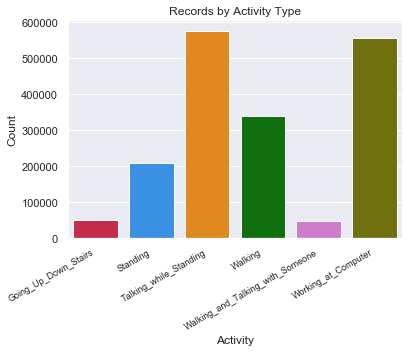

In [4]:
colours = ["crimson", "dodgerblue", "darkorange", "green", "orchid", "olive", "lightseagreen", "violet"]
sns.set(rc={'figure.figsize':(6, 4)})
fig = sns.countplot(x = "Activity" , data = data_frame, palette=colours)
fig.set_xticklabels(fig.get_xticklabels(), rotation=30, ha="right", fontsize = 9)
plt.xlabel("Activity")
plt.ylabel("Count")
plt.title("Records by Activity Type")
#plt.grid(True)
plt.show(fig)

# Normalize Training Data

In [5]:
# Normalize features for training data set (values between 0 and 1)
# Surpress warning for next 3 operation
pd.options.mode.chained_assignment = None  # default='warn'

data_frame['Ax'] = data_frame['Ax'] / data_frame['Ax'].max()
data_frame['Ay'] = data_frame['Ay'] / data_frame['Ay'].max()
data_frame['Az'] = data_frame['Az'] / data_frame['Az'].max()
# Round numbers
data_frame = data_frame.round({'Ax': 4, 'Ay': 4, 'Az': 4})

# Data Preprocessing

In [6]:
N_TIME_STEPS = 200
N_FEATURES = 3
step = 20
segments = []
labels = []

for i in range(0, len(data_frame) - N_TIME_STEPS, step):
    xs = data_frame['Ax'].values[i: i + N_TIME_STEPS]
    ys = data_frame['Ay'].values[i: i + N_TIME_STEPS]
    zs = data_frame['Az'].values[i: i + N_TIME_STEPS]
    label = stats.mode(data_frame['Activity'][i: i + N_TIME_STEPS])[0][0]
    segments.append([xs, ys, zs])
    labels.append(label)

C:\Users\admin\Anaconda3\lib\site-packages\scipy\stats\stats.py:245: RuntimeWarning: The input array could not be properly checked for nan values. nan values will be ignored.
  "values. nan values will be ignored.", RuntimeWarning)


In [7]:
reshaped_segments = np.asarray(segments, dtype= np.float32).reshape(-1, N_TIME_STEPS, N_FEATURES)
labels = np.asarray(pd.get_dummies(labels), dtype = np.float32)


In [8]:
print(reshaped_segments.shape)
print(labels[0])

(88809, 200, 3)
[1. 0. 0. 0. 0. 0.]


In [9]:
X_train, X_test, y_train, y_test = train_test_split(
        reshaped_segments, labels, test_size=0.2, random_state=RANDOM_SEED)

In [10]:
print('X_train : ', len(X_train))
print('y_train : ', len(y_train))
print('X_test : ', len(X_test))
print('y_test : ', len(y_test))

X_train :  71047
y_train :  71047
X_test :  17762
y_test :  17762


In [11]:
verbose = 1
epochs = 10
batch_size = 400

n_timesteps = X_train.shape[1]
n_features = X_train.shape[2]
n_outputs = y_train.shape[1]

print('n_timesteps : ', n_timesteps)
print('n_features : ', n_features)
print('n_outputs : ', n_outputs)

n_timesteps :  200
n_features :  3
n_outputs :  6


In [12]:
checkpoint = ModelCheckpoint("single_chest_weights.h5", monitor='val_acc', verbose=1, 
                             save_best_only=True, save_weights_only=False, mode='auto', period=1)

In [13]:
model = Sequential()
model.add(Conv1D(filters=64, kernel_size=3, activation='relu', input_shape=(n_timesteps,n_features)))
model.add(Conv1D(filters=64, kernel_size=3, activation='relu', padding = 'same'))
model.add(Dropout(0.4))
model.add(MaxPooling1D(pool_size=2))
model.add(Flatten())
model.add(Dense(100, activation='relu'))
model.add(Dense(n_outputs, activation='softmax'))

In [14]:
# Load Weights
final_model = Model(inputs = model.input, outputs = model.output)
#final_model.load_weights('./har_weights.h5')
final_model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

# fit network
history = final_model.fit(X_train, y_train, validation_data=(X_test, y_test), 
                    epochs=epochs, batch_size=batch_size, callbacks = [checkpoint], verbose=verbose)


# evaluate model
(loss, accuracy) = final_model.evaluate(X_test, y_test, batch_size=batch_size, verbose=verbose)
print("[INFO] loss={:.4f}, accuracy: {:.4f}%".format(loss, accuracy * 100))

Train on 71047 samples, validate on 17762 samples
Epoch 1/10
71047/71047 [==============================] - 95s 1ms/step - loss: 0.9259 - acc: 0.6832 - val_loss: 0.8341 - val_acc: 0.7307

Epoch 00001: val_acc improved from -inf to 0.73066, saving model to single_chest_weights.h5
Epoch 2/10
71047/71047 [==============================] - 105s 1ms/step - loss: 0.6767 - acc: 0.7699 - val_loss: 0.6788 - val_acc: 0.7783

Epoch 00002: val_acc improved from 0.73066 to 0.77829, saving model to single_chest_weights.h5
Epoch 3/10
71047/71047 [==============================] - 114s 2ms/step - loss: 0.5667 - acc: 0.8076 - val_loss: 0.5750 - val_acc: 0.8126

Epoch 00003: val_acc improved from 0.77829 to 0.81258, saving model to single_chest_weights.h5
Epoch 4/10
71047/71047 [==============================] - 115s 2ms/step - loss: 0.5124 - acc: 0.8255 - val_loss: 0.5357 - val_acc: 0.8322

Epoch 00004: val_acc improved from 0.81258 to 0.83223, saving model to single_chest_weights.h5
Epoch 5/10
71047/7

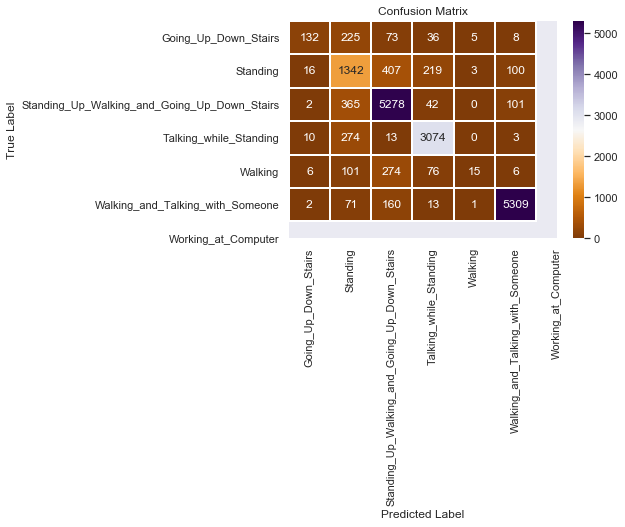

In [15]:

# Print confusion matrix for training data
y_pred_train = final_model.predict(X_train)
# Take the class with the highest probability from the train predictions
max_y_pred_train = np.argmax(y_pred_train, axis=1)
#print(classification_report(trainy, max_y_pred_train))

# confusion matrix
LABELS = ['Going_Up_Down_Stairs', 
          'Standing', 
          'Standing_Up_Walking_and_Going_Up_Down_Stairs', 
          'Talking_while_Standing', 
          'Walking', 
          'Walking_and_Talking_with_Someone', 
          'Working_at_Computer']

y_pred_test = final_model.predict(X_test)
# Take the class with the highest probability from the test predictions
max_y_pred_test = np.argmax(y_pred_test, axis=1)
max_y_test = np.argmax(y_test, axis=1)

matrix = metrics.confusion_matrix(max_y_test, max_y_pred_test)
plt.figure(figsize=(6, 4))
sns.heatmap(matrix,
            cmap='PuOr',
            linecolor='white',
            linewidths=1,
            xticklabels=LABELS,
            yticklabels=LABELS,
            annot=True,
            fmt='d')
plt.title('Confusion Matrix')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.show()
